In [124]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import wikipediaapi as wp
import re
import gacomm as gacomm
Lesmis = nx.read_gml("lesmis.gml")

### Content

- About the graph (text)
- Graph plain 

- Communities colored graph
- Character info (clickable on the node, displayed on the left)

- Degree distribution
- Degree centrality

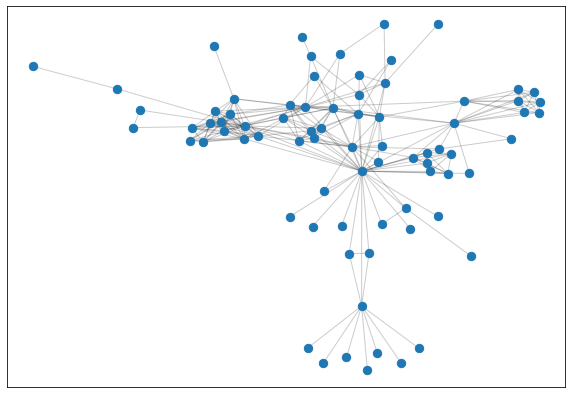

In [125]:
fig, axis = plt.subplots(nrows=1, ncols=1,figsize=(10, 7))
pos=nx.spring_layout(Lesmis)
es = nx.draw_networkx_edges(Lesmis, pos, alpha=0.2, ax=axis)
ns = nx.draw_networkx_nodes(Lesmis, pos, node_size=70, ax=axis)

In [126]:
df = pd.DataFrame(data={"character":list(Lesmis.nodes())})
df["degree_centrality"] = df.apply(lambda x: [x[1] for x in Lesmis.degree()])

In [127]:
wiki_en = wp.Wikipedia(language='en',
        extract_format=wp.ExtractFormat.HTML)
wiki_page = wiki_en.page("List of Les Misérables characters")
txt = wiki_page.text
lis = re.findall("<li>(.*?)</li>", txt)
char_info = [re.split("</b>",l.replace("<b>","")) for l in lis]
from unidecode import unidecode
char_info = [[unidecode(t[0].replace("(", "").replace(")", "").replace("-", "")),t[1].replace("– ","")] for t in char_info]

charss = []
charss = char_info.copy()

patron = charss[-4].copy()
child = charss[-1].copy()
charss += [child]
charss += [patron.copy() for r in range(3)]


left = ['Mlle Baptistine Myriel',
         'Magloire, Madame',
         'Blachevelle',
         'Azelma',
         'Mother Innocente',
         'Mademoiselle Gillenormand',
         'Colonel Georges Pontmercy',
         'Lesgle',
         'Bougon, Madame',
         'PatronMinette',
         'PatronMinette',
         'PatronMinette',
         'PatronMinette',
         'Two little boys',
         'Two little boys']
pair_of_left = ["MlleBaptistine","MmeMagloire",
                'Blacheville',"Anzelma",'MotherInnocent',
                'MlleGillenormand',
                "Pontmercy","Bossuet","MmeBurgon","Gueulemer",'Babet','Claquesous','Montparnasse',"Child1","Child2"]

for i in range(len(charss)):
    for j in range(len(left)):
        if charss[i][0] == left[j]:
            charss[i][0]= pair_of_left[j]
            left[j]="xx"
#             print(charss[i][0],left[j],pair_of_left[j])
            break
# charss

In [128]:
def get_info(name,chars):
    for c in chars:
        if re.search(name,c[0],re.IGNORECASE):
            chars.remove(c)
            return c[1]
            break
df["info"] = df["character"].apply(lambda x: get_info(x,charss))

## Add Character Info Manually

In [129]:
df.head()

,character,degree_centrality,info
0,Myriel,10,The Bishop of Digne (full name Charles-Franço...
1,Napoleon,1,None
2,MlleBaptistine,3,Bishop Myriel's sister. She loves and venerat...
3,MmeMagloire,3,Domestic servant to Bishop Myriel and his sis...
4,CountessDeLo,1,None


In [130]:
no_info_characters = list(df[df["info"].isnull()]["character"])

In [131]:
import csv
chars_manually = {}
with open('addcharinfomanually.csv', mode="r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',',quotechar='"')
    for x in csv_reader:
        chars_manually[x[0]] =" ".join(x[1:])

In [143]:
df.loc[df['character'] == "Valjean", "info"].values[0]

" (also known as Monsieur Madeleine, Ultime Fauchelevent, Monsieur Leblanc, and Urbain Fabre) The protagonist of the novel. Convicted for stealing a loaf of bread to feed his sister's seven starving children and sent to prison for five years, he is paroled from prison nineteen years later (after four unsuccessful escape attempts added twelve years and fighting back during the second escape attempt added two extra years). Rejected by society for being a former convict, he encounters Bishop Myriel, who turns his life around by showing him mercy and encouraging him to become a new man. While sitting and pondering what Bishop Myriel had said, he puts his shoe on a forty-sou piece dropped by a young wanderer. Valjean threatens the boy with his stick when the boy attempts to rouse Valjean from his reverie and recover his money. He tells a passing priest his name, and the name of the boy, and this allows the police to charge him with armed robbery a sentence that, if he were caught again, wou

In [144]:
def getinfomanually(char):
    if char in no_info_characters:
        return chars_manually[char]
    else:
        return df.loc[df['character'] == char, "info"].values[0]

df["info"] = df["character"].apply(lambda x: getinfomanually(x))

In [145]:
df.head()

,character,degree_centrality,info
0,Myriel,10,The Bishop of Digne (full name Charles-Franço...
1,Napoleon,1,A French statesman and military leader who be...
2,MlleBaptistine,3,Bishop Myriel's sister. She loves and venerat...
3,MmeMagloire,3,Domestic servant to Bishop Myriel and his sis...
4,CountessDeLo,1,


## Community Detection

In [154]:
subsets = gacomm.community_detection(Lesmis.nodes(),Lesmis.edges())

In [155]:
def find_group(name,subsets):
    for i in range(len(subsets)):
        if name in subsets[i]:
            return i
            break
    
df["community"] = df["character"].apply(lambda x: find_group(x,subsets))

In [156]:
len(subsets)

10

### Degree distribution, Degree Centrality

<AxesSubplot:xlabel='degree_centrality'>

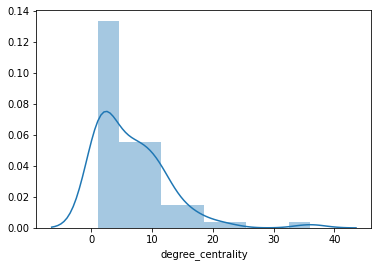

In [157]:
sn.distplot(df["degree_centrality"])

### Centralities

In [158]:
eigenvector_centrality = nx.eigenvector_centrality(Lesmis)

In [159]:
df["eigenvector_centrality"]=df["character"].apply(lambda character: eigenvector_centrality[character])

In [160]:
betweenness_centrality = nx.betweenness_centrality(Lesmis)

In [161]:
df["betweenness_centrality"]=df["character"].apply(lambda character: betweenness_centrality[character])

In [162]:
closeness_centrality=nx.closeness_centrality(Lesmis)

In [163]:
df["closeness_centrality"]=df["character"].apply(lambda character: closeness_centrality[character])

### Shortest Path

In [164]:
shortest_path_length=nx.all_pairs_shortest_path_length(Lesmis)
highest = 0
for i in range(77):
    paths = next(shortest_path_length)[1]
    for key in paths:
        if paths[key] > highest:
            highest=paths[key]
            


In [165]:
shortest_path_length=nx.all_pairs_shortest_path_length(Lesmis)
longest_shortest_path=[]

In [166]:
for i in range(77):
    paths=next(shortest_path_length)
    for key in paths[1]:
        if paths[1][key]==highest:
            longest_shortest_path.append([paths[0],key])
            break
#     else:
#         continue  
#     break

In [167]:
longest_shortest_path

[['Napoleon', 'Jondrette'],
 ['CountessDeLo', 'Jondrette'],
 ['Geborand', 'Jondrette'],
 ['Champtercier', 'Jondrette'],
 ['Cravatte', 'Jondrette'],
 ['Count', 'Jondrette'],
 ['OldMan', 'Jondrette'],
 ['Listolier', 'Jondrette'],
 ['Fameuil', 'Jondrette'],
 ['Blacheville', 'Jondrette'],
 ['Favourite', 'Jondrette'],
 ['Dahlia', 'Jondrette'],
 ['Zephine', 'Jondrette'],
 ['Perpetue', 'Jondrette'],
 ['Gribier', 'Jondrette'],
 ['Jondrette', 'Napoleon'],
 ['Magnon', 'Jondrette'],
 ['MmePontmercy', 'Jondrette'],
 ['MlleVaubois', 'Jondrette'],
 ['MotherPlutarch', 'Perpetue']]

In [168]:
shortest_path = nx.shortest_path(Lesmis)

In [169]:
list_longest_shortest_path = []
for key in shortest_path:
    for k in shortest_path[key]:
        if key == longest_shortest_path[0][0] and k == longest_shortest_path[0][1]:
            list_longest_shortest_path = shortest_path[key][k]
            break
    else:
        continue
    break

In [170]:
shortest_path_edges = []
for i in range(len(list_longest_shortest_path)-1):
    shortest_path_edges.append([list_longest_shortest_path[i],list_longest_shortest_path[i+1]])

In [171]:
shortest_path_edges

[['Napoleon', 'Myriel'],
 ['Myriel', 'Valjean'],
 ['Valjean', 'Gavroche'],
 ['Gavroche', 'MmeBurgon'],
 ['MmeBurgon', 'Jondrette']]

### Spanning tree

In [172]:
from networkx.algorithms import tree
mst = tree.minimum_spanning_edges(Lesmis, algorithm='prim', data=False)
tree_edgelist = list(mst)

### Plot Summary

In [173]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

url = 'https://www.sparknotes.com/lit/lesmis/summary/'
response = requests.get(url)
soup = BeautifulSoup(response.text)
soup_text = soup.prettify()

plot = re.findall("<p>\n\s+[\S\n\s]+[.]\n\s+</p>", soup_text)
plot_summary=plot[0].replace("\n", " ").replace("       ","").replace("      ","").replace("<p>","").split("</p>")

In [174]:
plot_summary_short = "After years as a prisoner, Jean Valjean is freed by Javert, the officer in charge of the prison workforce. Valjean promptly breaks parole but later uses money from stolen silver to reinvent himself as a mayor and factory owner. Javert vows to bring Valjean back to prison. Eight years later, Valjean becomes the guardian of a child named Cosette after her mother's death, but Javert's relentless pursuit means that peace will be a long time coming."

# Drawing

In [175]:
d_2 = {}

In [176]:
d_2 = {
        "shortest_path_nodes":list_longest_shortest_path,
        "shortest_path":shortest_path_edges,
        "spanning_tree":tree_edgelist
      }

In [177]:
d_2["description"] = {
    "introduction":"Welcome! This dashboard is an experiment of reviewing a book by its network. A network is a structure consisting of objects(nodes) with connections(edges) among them, represented as circle and line. To the right is a network of coappearance of characters in the novel Les Miserables. Two characters are said to be connected if they appear in a same chapter. Click on the node to get info about the character. This menu lists some measurements with which we can interpret the network.",
    "plot_summary":plot_summary_short,
    "degree_centrality":"Degree centrality is a measure that counts how many neighbors a node has. The colors of the nodes shows the centrality, the brighter the greater its degree centrality.",
    "eigenvector_centrality":"A measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.",
    "betweenness_centrality":"Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. It was introduced as a measure for quantifying the control of a human on the communication between other humans in a social network.",
    "closeness_centrality":"The average length of the shortest path between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes",
    "spanning_tree":"A subset of a graph, which has all the nodes covered with minimum possible number of edges. Hence, a spanning tree does not have cycles and it cannot be disconnected.",
    "shortest_path":"A shortest path, or geodesic path, between two nodes in a graph is a path with the minimum number of edges. The highlighted paths is the longest one among all shortest paths of all possible pair of nodes.",
    "community":"Showing the community structure within the network. Community is defined as group of nodes which are densely connected with each other internally. Nodes which belong to a community have the same color."
}

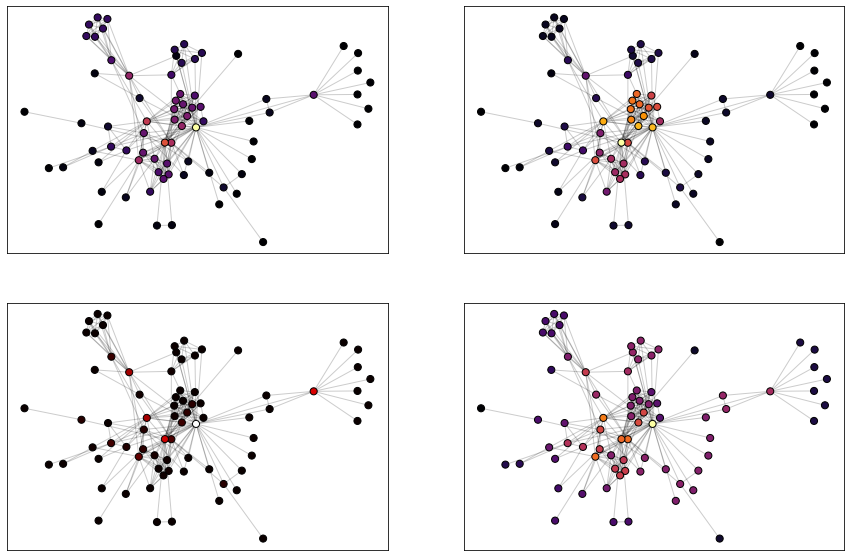

In [178]:
pos=nx.spring_layout(Lesmis)
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
pos = nx.spring_layout(Lesmis)

centralities = [
    list(df["degree_centrality"]),
    list(df["eigenvector_centrality"]),
    list(df["betweenness_centrality"]),
    list(df["closeness_centrality"])]

colors_centralities = [plt.cm.inferno,plt.cm.inferno,plt.cm.hot,plt.cm.inferno]

i = 0
for row in axes:
    for ax in row:
        es = nx.draw_networkx_edges(Lesmis, pos, alpha=0.2, ax=ax)
        ns = nx.draw_networkx_nodes(Lesmis, pos, edgecolors="k", nodelist=Lesmis.nodes(), node_color=centralities[i],
                                        node_size=50, cmap=colors_centralities[i], ax=ax)
        i+=1
        

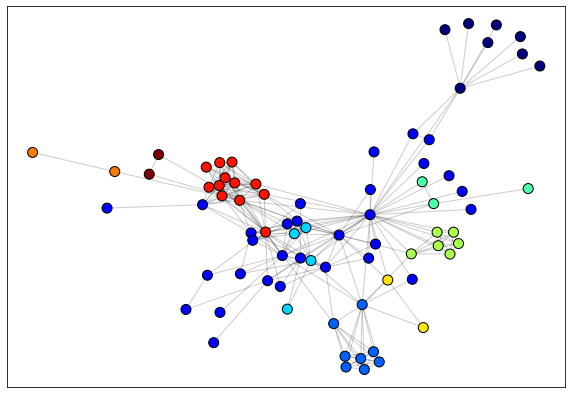

In [179]:
# Group
pos=nx.spring_layout(Lesmis)
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,7))
es = nx.draw_networkx_edges(Lesmis, pos, alpha=0.2, ax=axes)
ns = nx.draw_networkx_nodes(Lesmis, pos, edgecolors="k", nodelist=Lesmis.nodes(), node_color=df["community"],
                                        node_size=100, cmap=plt.cm.jet, ax=axes)
    

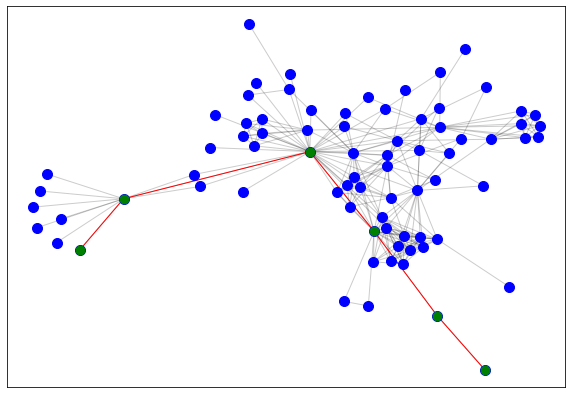

In [180]:
# Group
pos=nx.spring_layout(Lesmis)
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,7))
es = nx.draw_networkx_edges(Lesmis, pos, alpha=0.2, ax=axes)
es = nx.draw_networkx_edges(Lesmis, pos, edgelist=d_2["shortest_path"],edge_color="r", alpha=1, ax=axes)
ns = nx.draw_networkx_nodes(Lesmis, pos, nodelist=Lesmis.nodes(), node_color="b",
                                        node_size=100, cmap=plt.cm.jet, ax=axes)
ns = nx.draw_networkx_nodes(Lesmis, pos, nodelist=d_2["shortest_path_nodes"], node_color="g",
                                        node_size=80, cmap=plt.cm.jet, ax=axes)
    

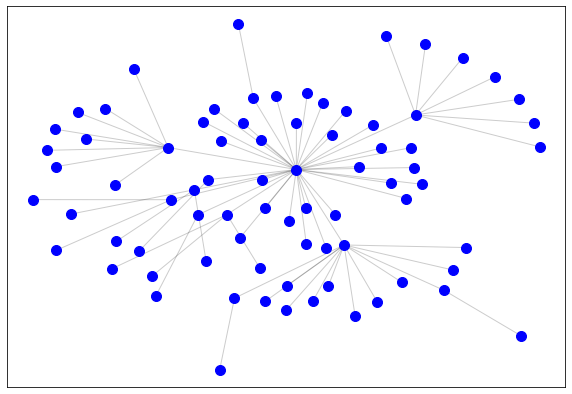

In [181]:
# Spanning Tree
pos=nx.kamada_kawai_layout(Lesmis)
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,7))
es = nx.draw_networkx_edges(Lesmis, pos, edgelist = d_2["spanning_tree"],alpha=0.2, ax=axes)
ns = nx.draw_networkx_nodes(Lesmis, pos, nodelist=Lesmis.nodes(), node_color="b",
                                        node_size=100, cmap=plt.cm.jet, ax=axes)

In [182]:
df.head()

,character,degree_centrality,info,community,eigenvector_centrality,betweenness_centrality,closeness_centrality
0,Myriel,10,The Bishop of Digne (full name Charles-Franço...,0,0.028134,0.176842,0.429379
1,Napoleon,1,A French statesman and military leader who be...,0,0.002343,0.000000,0.301587
2,MlleBaptistine,3,Bishop Myriel's sister. She loves and venerat...,1,0.026873,0.000000,0.413043
3,MmeMagloire,3,Domestic servant to Bishop Myriel and his sis...,1,0.026873,0.000000,0.413043
4,CountessDeLo,1,,0,0.002343,0.000000,0.301587


In [183]:
d_2["nodes"]=list(Lesmis.nodes())
d_2["edges"]=list(Lesmis.edges())

In [184]:
import json
result = df.to_json(orient="records")

In [185]:
parsed = json.loads(result)
with open('lesmischars.json', 'w') as outfile:
    json.dump(result, outfile)

In [186]:
with open('lesmisgraph.json','w') as outfile:
    json.dump(d_2,outfile)